In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import sklearn.metrics as sm
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

from statsmodels.tsa.stattools import adfuller
from scipy import stats

### Load the dataset

In [4]:
raw_df = pd.read_csv('google-stock-dataset-Daily.csv')
raw_df = raw_df.drop(['Unnamed: 0','Adj Close'], axis=1)
raw_df['Date']=pd.to_datetime(raw_df['Date'])
raw_df.set_index("Date", inplace=True)
raw_df


,Price,High,Low,Close,Volume
Date,,,,,
2013-04-15,19.67,19.94,19.44,19.57,98025876
2013-04-16,19.68,19.92,19.62,19.85,69610320
2013-04-17,19.69,19.79,19.47,19.58,81398520
2013-04-18,19.65,19.66,19.05,19.17,132767100
2013-04-19,19.25,20.11,19.18,20.02,231895872
...,...,...,...,...,...
2023-03-27,104.62,104.76,101.93,102.46,31120900
2023-03-28,102.44,102.45,99.74,101.03,32057900
2023-03-29,102.28,102.49,100.65,101.39,28779600


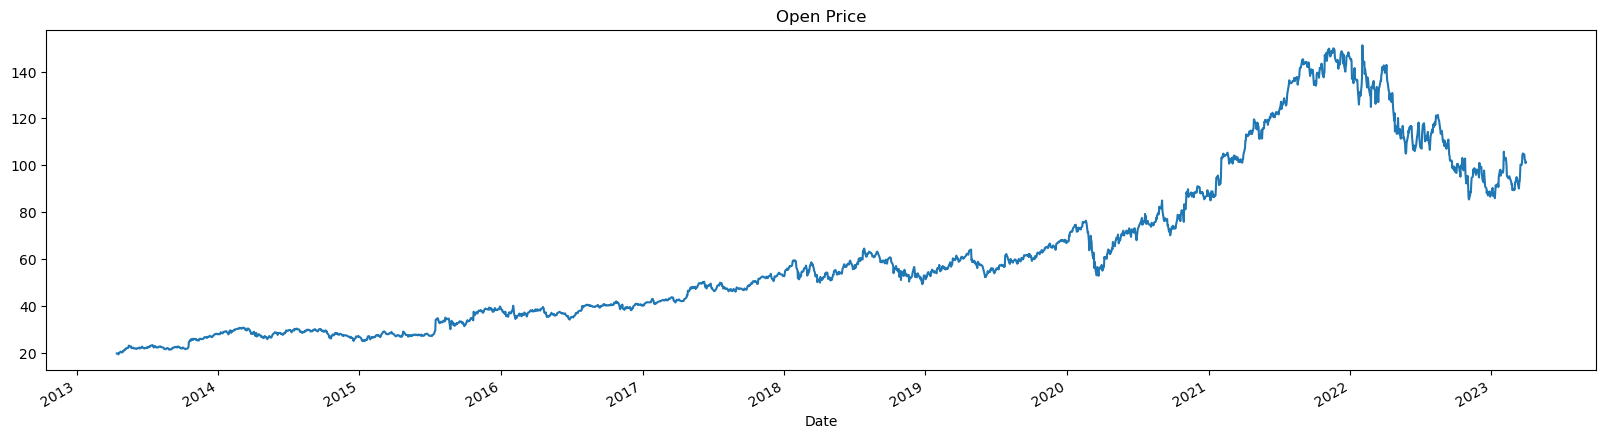

In [3]:
raw_df.Price.plot(figsize=(20,5), title="Open Price")
plt.show()

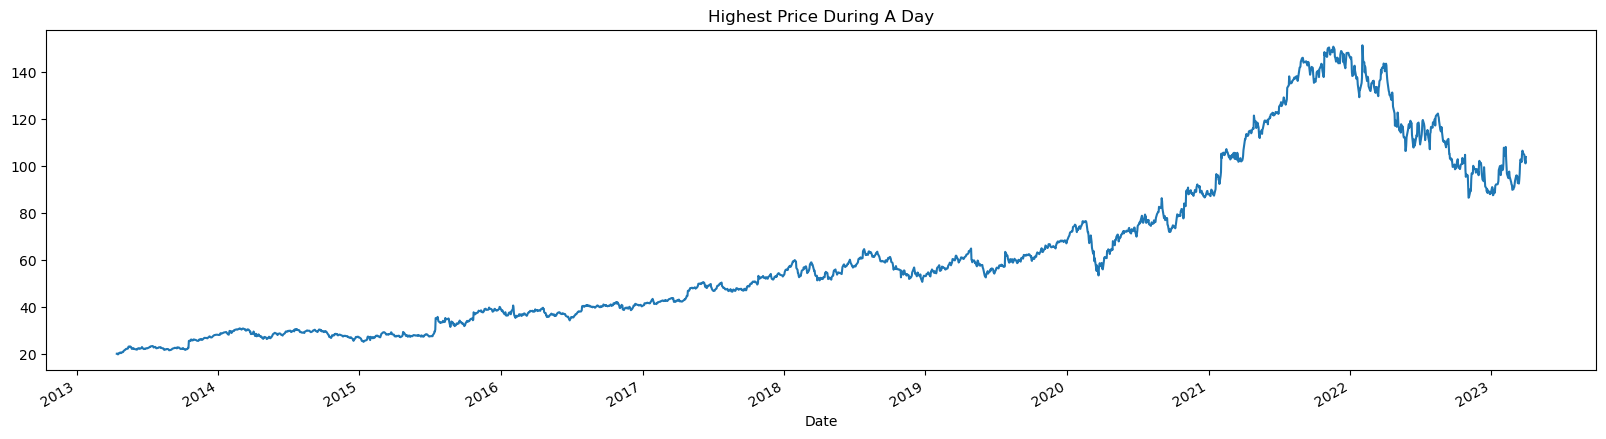

In [4]:
raw_df.High.plot(figsize=(20,5), title="Highest Price During A Day")
plt.show()

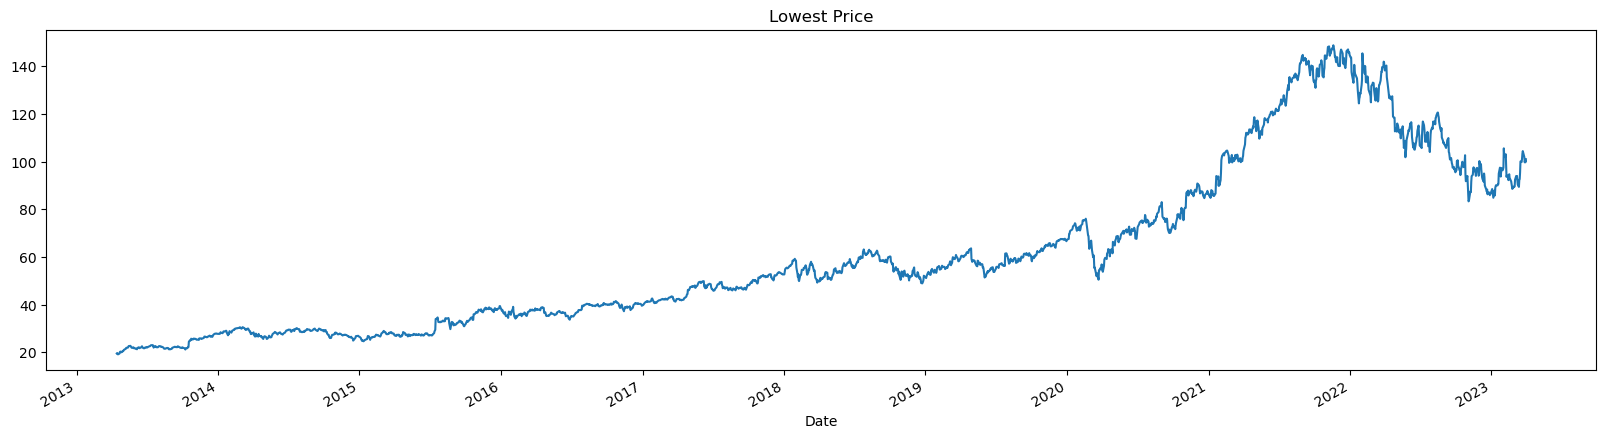

In [5]:
raw_df.Low.plot(figsize=(20,5), title="Lowest Price")
plt.show()

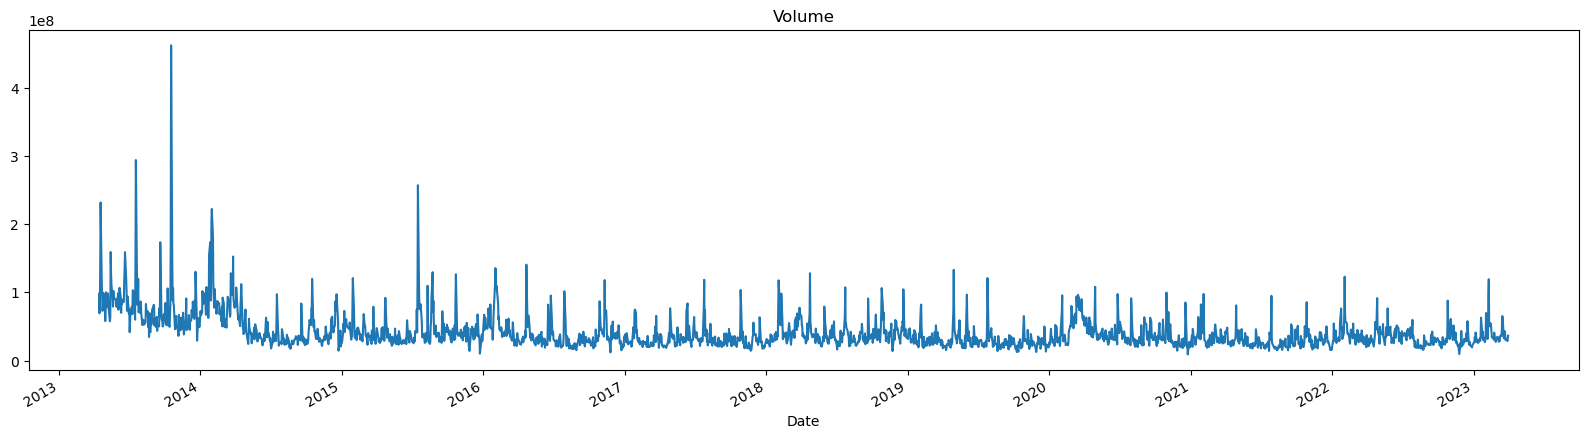

In [6]:
raw_df.Volume.plot(figsize=(20,5), title="Volume")
plt.show()

### Check for normality


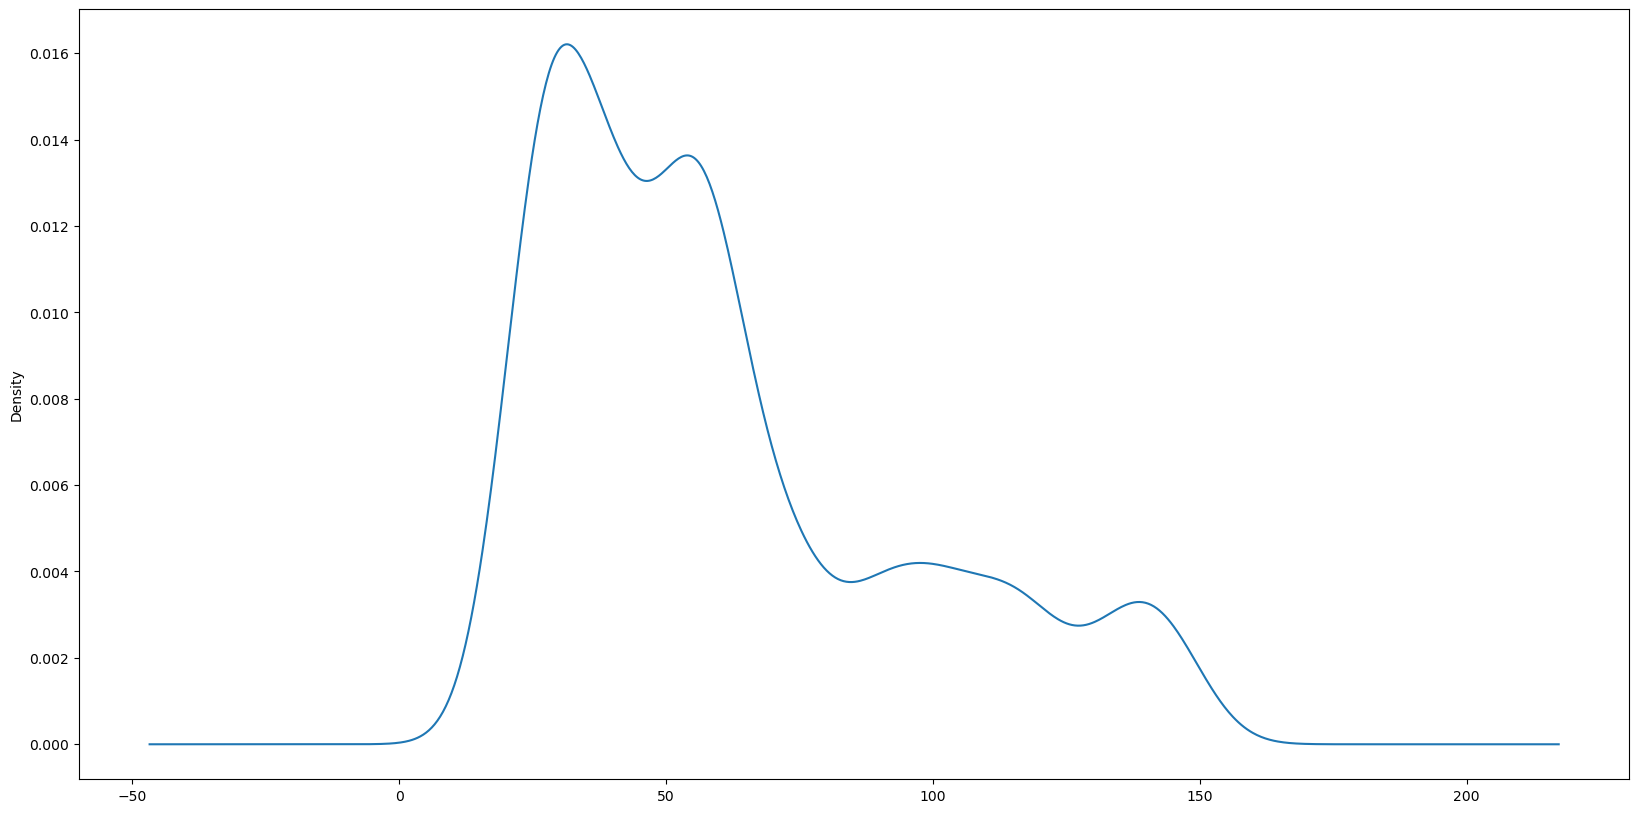

In [108]:
# Density 
raw_df["Price"].plot(kind='kde', figsize=(20, 10))
plt.show()

### Heatmap

<AxesSubplot:>

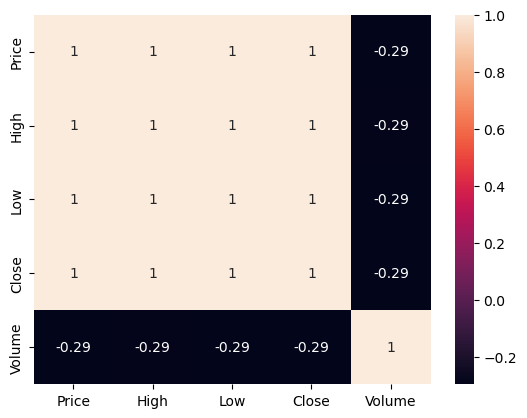

In [93]:
sns.heatmap(raw_df.corr(),robust=True, annot=True)

In [5]:
# Collect and clean the data
raw_df = pd.read_csv('google-stock-dataset-Daily.csv')
raw_df = raw_df.drop(['Unnamed: 0', 'Adj Close','Volume'], axis=1)
raw_df['Date']=pd.to_datetime(raw_df['Date'])
raw_df.set_index("Date", inplace=True)
raw_df

,Price,High,Low,Close
Date,,,,
2013-04-15,19.67,19.94,19.44,19.57
2013-04-16,19.68,19.92,19.62,19.85
2013-04-17,19.69,19.79,19.47,19.58
2013-04-18,19.65,19.66,19.05,19.17
2013-04-19,19.25,20.11,19.18,20.02
...,...,...,...,...
2023-03-27,104.62,104.76,101.93,102.46
2023-03-28,102.44,102.45,99.74,101.03
2023-03-29,102.28,102.49,100.65,101.39


In [19]:
#Add time-step feature
df_copy=raw_df.copy()
raw_df['Time']=np.arange(len(raw_df.index))
raw_df

,Price,High,Low,Close,Time
Date,,,,,
2013-04-15,19.67,19.94,19.44,19.57,0
2013-04-16,19.68,19.92,19.62,19.85,1
2013-04-17,19.69,19.79,19.47,19.58,2
2013-04-18,19.65,19.66,19.05,19.17,3
2013-04-19,19.25,20.11,19.18,20.02,4
...,...,...,...,...,...
2023-03-27,104.62,104.76,101.93,102.46,2505
2023-03-28,102.44,102.45,99.74,101.03,2506
2023-03-29,102.28,102.49,100.65,101.39,2507


In [12]:
#add lag feature
df_copy['Lag_1']=df_copy['Close'].shift(1)
"""df_copy['Lag_2']=df_copy['Lag_1'].shift(1)
df_copy['Lag_3']=df_copy['Lag_2'].shift(1)"""
df_copy.head()

,Price,High,Low,Close,Time,Lag_1
Date,,,,,,
2013-04-15,19.67,19.94,19.44,19.57,0,NaN
2013-04-16,19.68,19.92,19.62,19.85,1,19.57
2013-04-17,19.69,19.79,19.47,19.58,2,19.85
2013-04-18,19.65,19.66,19.05,19.17,3,19.58
2013-04-19,19.25,20.11,19.18,20.02,4,19.17


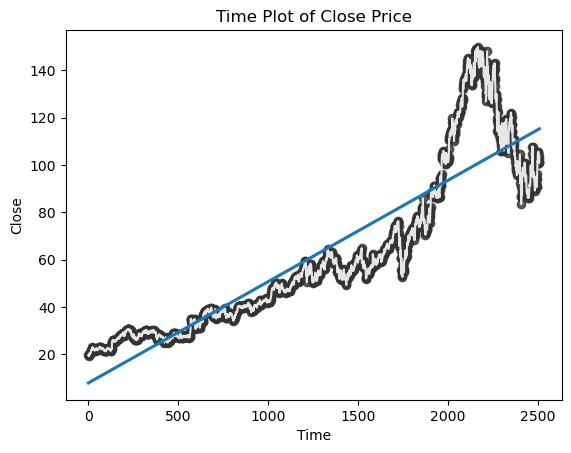

In [13]:
fig, ax = plt.subplots()
ax.plot('Time', 'Close', data=df_copy, color='0.9')
ax = sns.regplot(x='Time', y='Close', data=df_copy, ci=None, scatter_kws=dict(color='0.2'))
ax.set_title('Time Plot of Close Price');

Training scores: 0.09993338293269259
Test scores: 0.7842746223392815


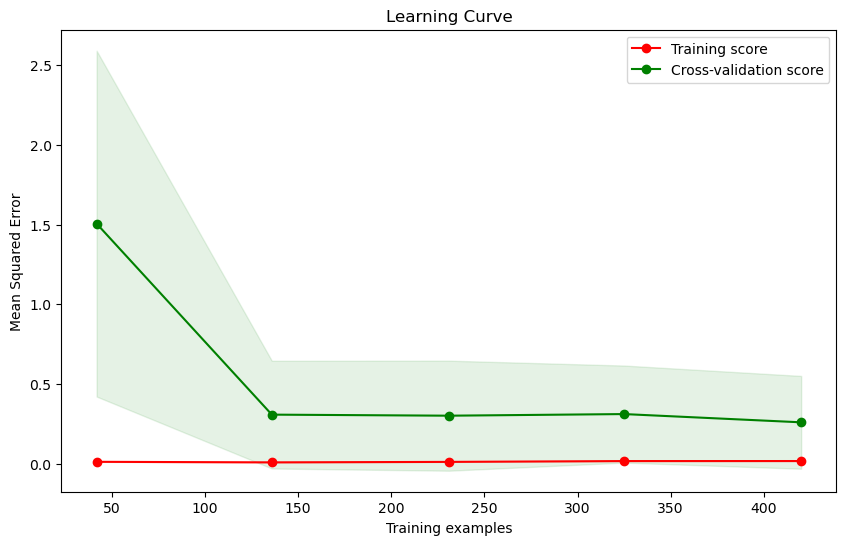

0.9998206104403017

In [22]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

# Create X and y variables
X=raw_df.drop(['Close'], axis=1).values
y=raw_df['Close'].values

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Definelinear regression model
reg = LinearRegression()

# Create empty lists to store the scores for each fold
train_scores = []
test_scores = []

# Loop through each split and train/test the model
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the linear regression model
    reg.fit(X_train, y_train)

    # Predict on training and test sets
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)

    # Calculate mean squared error
    train_score = mean_squared_error(y_train, y_train_pred)
    test_score = mean_squared_error(y_test, y_test_pred)

    # Append scores to the lists
    train_scores.append(train_score)
    test_scores.append(test_score)
# Print the scores
print("Training scores:", train_scores[-1])
print("Test scores:", test_scores[-1])

# Set the parameters for learning_curve
train_sizes = np.linspace(0.1, 1.0, 5)
scoring = 'neg_mean_squared_error'  # Choose an appropriate scoring metric

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=reg,
    X=X,
    y=y,
    train_sizes=train_sizes,
    cv=tscv,
    scoring=scoring,
    n_jobs=1  # Set the number of jobs to run in parallel, adjust as needed
)

# Calculate mean and standard deviation of scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r"
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g"
)
plt.plot(
    train_sizes,
    train_scores_mean,
    'o-', color="r",
    label="Training score"
)
plt.plot(
    train_sizes,
    test_scores_mean,
    'o-', color="g",
    label="Cross-validation score"
)
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()
reg.score(X_test,y_test)
reg.score(X_train, y_train)
